# Simulating protocol 3, cell 5

In this notebook, I'll simulate protocol 3 to get synthetic data similar to the real data. I'll construct residuals from ODE solution and from splines fits. 

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. The protocols that I have the myokit version are 2, 3, 4, 5

- First load the data
- compare ODE solution and data
- check Chon's and Michael's parameters

In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
from scipy.interpolate import interp1d

## Meta parameters

In [2]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_splines = False
#FileNameSplines = 'protocol3_cell5_splines_params_largerCurrents.npy' 
#FileNameSplinesWeights = 'protocol3_cell5_splines_params_largerCurrents_weights.npy'
if saved_splines:
    print('This code will load the splines parameters instead of fitting them')

## Load the data and simulate it

In [3]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
#protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)

# Create an analytical simulation 
markov_sim_pr3 = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol_3)
# Log times will be equal to the times from the data
hh_log_pr3 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)


plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, pr3_current, '.', alpha = 0.2,label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'], '-', label='ODE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr']-pr3_current, '.', alpha = 0.2, label='error')
plt.legend(loc='upper left')
plt.ylim([-1.5,1.5])
plt.show()


42


## Parameters

**Kylies parameters**

These are the ones by default in the current myokit beattie-2017-ikr-markov.mmt file

p1 = 2.26e-4 [1/ms]

p2 = 0.06990 [1/mV]

p3 = 3.45e-5 [1/ms]

p4 = 0.05462 [1/mV]

p5 = 0.08730 [1/ms]

p6 = 8.91e-3 [1/mV]

p7 = 5.15e-3 [1/ms]

p8 = 0.03158 [1/mV]

p9 = 0.15240 [uS]


**Michael parameters**

Parameters from method 4 look pretty similar to Kylies data, but they are not exactly the same. 

Cell 5 | Method 1    | Method 2    | Method 3    | Method 4  

p1     | 6.55032e-05 | 2.99734e-04 | 2.10551e-04 | 2.26087e-04

p2     | 8.30140e-02 | 1.03038e-01 | 6.57995e-02 | 6.99203e-02

p3     | 2.42112e-05 | 3.50809e-05 | 3.31717e-06 | 3.44950e-05

p4     | 5.75630e-02 | 4.62585e-02 | 7.43103e-02 | 5.46121e-02

p5     | 8.63963e-02 | 7.95833e-02 | 8.73244e-02 | 8.73295e-02

p6     | 1.16387e-02 | 1.40118e-02 | 7.33380e-03 | 8.93130e-03

p7     | 3.90830e-03 | 2.49811e-03 | 6.16551e-03 | 5.14929e-03

p8     | 4.30250e-02 | 5.24240e-02 | 3.15741e-02 | 3.15613e-02

p9     | 1.29138e-01 | 1.13935e-01 | 1.33898e-01 | 1.52427e-01


**I guess I should try the 5 parameter sets**


Some examples on how to change the parameters from Michael tutorials


# Run a simulation
t_max = 15400
times = np.arange(0, t_max, 0.1)
s_1 = myokit.Simulation(model, protocol)
log_1 = s_1.run(t_max, log_times=times, log=['ikr.IKr'])

# Create a BenchMarker, to time the next operations
b = myokit.Benchmarker()

# Modify using the model API, and run a simulation
model.get('ikr.p1').set_rhs(1e-4)
s_2 = myokit.Simulation(model, protocol)
log_2 = s_2.run(t_max, log_times=times, log=['ikr.IKr'])
print('Time taken: ' + str(b.time()))

# Modify by changing a simulation object
b.reset()
s_1.reset()                       # Reset the first simulation to t=0
s_1.set_constant('ikr.p1', 1e-4)  # Update a parameter value
log_3 = s_1.run(t_max, log_times=times, log=['ikr.IKr'])
print('Time taken: ' + str(b.time()))


# Update the parameters
for i, p in enumerate(parameters):
    self.sim.set_constant('ikr.p' + str(1 + i), p)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


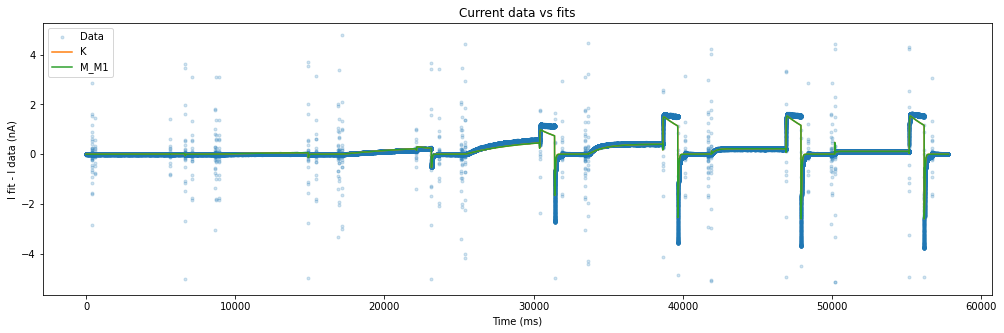

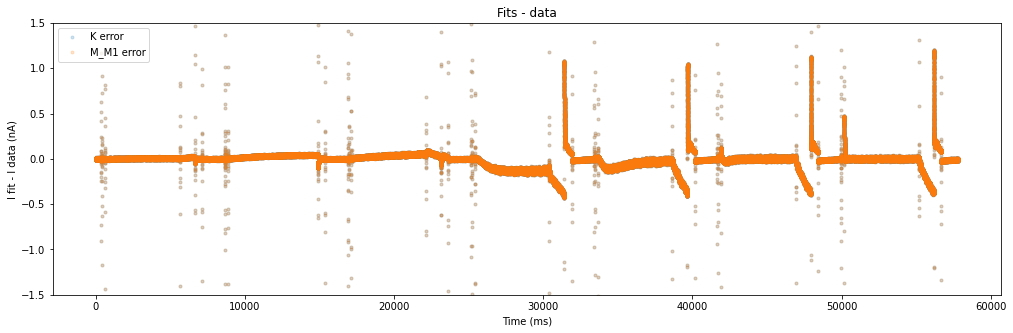

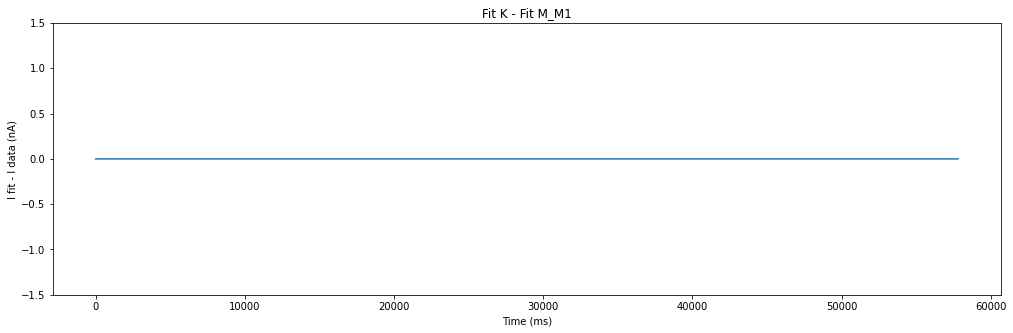

In [16]:
# Define the different parameter sets
parameters_Kylie = np.array([2.26e-4, 0.06990, 3.45e-5, 0.05462, 0.08730, 8.91e-3, 5.15e-3, 0.03158, 0.15240])
parameters_Michael_M1 = np.array([6.55032e-05, 8.30140e-02, 2.42112e-05, 5.75630e-02, 8.63963e-02, 1.16387e-02, 3.90830e-03, 4.30250e-02, 1.29138e-01])
parameters_Michael_M2 = np.array([2.99734e-04, 1.03038e-01, 3.50809e-05, 4.62585e-02, 7.95833e-02, 1.40118e-02,  2.49811e-03, 5.24240e-02, 1.13935e-01])
parameters_Michael_M3 = np.array([2.10551e-04, 6.57995e-02, 3.31717e-06, 7.43103e-02, 8.73244e-02, 7.33380e-03, 6.16551e-03, 3.15741e-02, 1.33898e-01])
parameters_Michael_M4 = np.array([2.26087e-04, 6.99203e-02, 3.44950e-05, 5.46121e-02, 8.73295e-02, 8.93130e-03, 5.14929e-03,  3.15613e-02, 1.52427e-01])


b = myokit.Benchmarker()
# run simulation with Kylies parameters
b.reset()
markov_sim_pr3.reset()                       # Reset the first simulation to t=0
for i, p in enumerate(parameters_Kylie):
    print(i)
    markov_sim_pr3.set_constant('ikr.p' + str(1 + i), p)
hh_log_pr3_kylie = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)

# run simulation with Michael_M1 parameters
b = myokit.Benchmarker()
b.reset()
markov_sim_pr3.reset()                       # Reset the first simulation to t=0
for i, p in enumerate(parameters_Michael_M4):
    print(i)
    markov_sim_pr3.set_constant('ikr.p' + str(1 + i), p)
hh_log_pr3_Michael_M1 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)



plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('I fit - I data (nA)')
plt.plot(pr3_time, pr3_current,'.',alpha=0.2, label='Data')
plt.plot(pr3_time, hh_log_pr3_kylie['ikr.IKr'], label='K')
plt.plot(pr3_time, hh_log_pr3_Michael_M1['ikr.IKr'], label='M_M1')
plt.legend(loc='upper left')
plt.title('Current data vs fits')
plt.show()



plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('I fit - I data (nA)')
plt.plot(pr3_time, hh_log_pr3_kylie['ikr.IKr']-pr3_current,'.',alpha=0.2, label='K error')
plt.plot(pr3_time, hh_log_pr3_Michael_M1['ikr.IKr']-pr3_current,'.',alpha=0.2, label='M_M1 error')
plt.legend(loc='upper left')
plt.title('Fits - data')
plt.ylim([-1.5,1.5])
plt.show()


plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('I fit - I data (nA)')
plt.plot(pr3_time, hh_log_pr3_kylie['ikr.IKr']-hh_log_pr3_Michael_M1['ikr.IKr'])
#plt.legend(loc='upper left')
plt.title('Fit K - Fit M_M1')
plt.ylim([-1.5,1.5])
plt.show()



## Separate by voltage and define color scheme

In [4]:
# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))

# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])